# ДЗ 2 по графам
## Работу выполнил Смирнов Александр

# 1) Data upload

In [46]:
from openpyxl import load_workbook
from matplotlib import pyplot as plt 
import numpy as np


wb = load_workbook(filename='globalterrorismdb_0718dist.xlsx', read_only=True)

In [164]:
wb.sheetnames

['Data']

In [48]:
sheet = wb['Data']

In [49]:
num_of_cols = sheet.max_column
num_of_rows = sheet.max_row

In [50]:
values = sheet.values

eventId = {}
related = {}
for row in values:
    if row[1] in eventId:
        eventId[row[1]].append(row[0])
        related[row[1]].append(row[-1])
    else:
        eventId[row[1]] = [row[0]]
        related[row[1]] = [row[-1]]
    


In [51]:
eventId.keys()

dict_keys(['iyear', 2000, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

Таким образом, мы получили данные за 2000+ годы.

# 2,3)  Graph Generation

Теперь обработаем их, взяв максимальные клики, убрав из них узлы и мультиребра

In [180]:
import networkx as nx

def gen_graph(year):
    G = nx.Graph()
    for node, edges in zip(eventId[year], related[year]):
        if edges:
            for edge in edges.split(','):
                try:
                    to_node = (int(edge.strip().strip('\\').strip()))

                    if node != to_node:
                        G.add_edge(node, to_node)
                except:
                    for edge_0 in edge.split(' and '):
                        to_node = (int(edge_0.strip().strip('\\').strip()))
                        
                        if node != to_node:
                            G.add_edge(node, to_node)
    return G
       

def get_max_component(G):
    graphs = list(nx.connected_component_subgraphs(G))
    return max(graphs, key=len)


def get_graph(year):
    return nx.convert_node_labels_to_integers(get_max_component(gen_graph(year)))

In [53]:
def draw_graph(G):
    print(len(G))
    plt.figure(3,figsize=(30,30))
    nx.draw_spring(G, with_labels=True, node_size=40, font_size=50, node_color='skyblue')
    #nx.draw(Vienna, with_labels=True, node_size=55, font_size=10, node_color='skyblue')
    #nx.draw_random(G)  
    #nx.draw_circular(G)  
    #nx.draw_spectral(G)  
    #nx.draw_spring(G) 
    plt.show()

После быстрого просмотра всех полученных графов, появилось чувство, что все они полные.

Т.к. они все без мультиребер, узлов и изолированных вершин, проверим их на полноту, посчитав количество их ребер

In [150]:
def check_if_graph_complete(G):
    num_of_nodes = len(G)
    num_of_edges = len(G.edges())
    num_of_edges_in_complete = num_of_nodes * (num_of_nodes - 1) / 2
    if num_of_edges == num_of_edges_in_complete:
        # print('This is a complete Graph')
        return True
    return False

In [167]:
Graphs = [get_graph(2000 + year) for year in range(18)]

In [151]:
complete = [check_if_graph_complete(G) for G in Graphs]
print(len(Graphs), sum(complete))

18 17


In [152]:
for i, G in enumerate(Graphs):
    if not check_if_graph_complete(G):
        print(i, 'graph is not complete')
    

9 graph is not complete


Теперь посмотрим размеры графов

In [184]:
for i, g in enumerate(Graphs):
    print(i, len(g))

0 39
1 9
2 18
3 11
4 8
5 8
6 7
7 10
8 18
9 16
10 25
11 16
12 43
13 36
14 49
15 24
16 80
17 42


В качестве основных графов для сравнения я решил взять 2 полных графа 2012 и 2016 года.

In [ ]:
G1 = Graphs[12]
G2 = Graphs[16]

Также для разнообразия я решил соединить мостом 2 самые большие компоненты другого года, к примеру, можно взять 10 год.


In [487]:
set_2010 = gen_graph(2010)

components_2010 = list(nx.connected_component_subgraphs(set_2010))
components_2010.sort(key=lambda x: len(x.edges()))

print('Largest component is complete:', check_if_graph_complete(components_2010[-1]))
print('Second largest component is complete:', check_if_graph_complete(components_2010[-2]))
print('Largest:', len(components_2010[-1]))
print('Second largest:', len(components_2010[-2]))

Largest component is complete: True
Second largest component is complete: True
Largest: 25
Second largest: 15


Они также оказались полными.

Теперь соединим их мостом.

In [434]:
set_2010.add_edge(list(components_2010[-1].nodes())[0], list(components_2010[-2].nodes())[0])
G0 = nx.convert_node_labels_to_integers(get_max_component(set_2010))

40


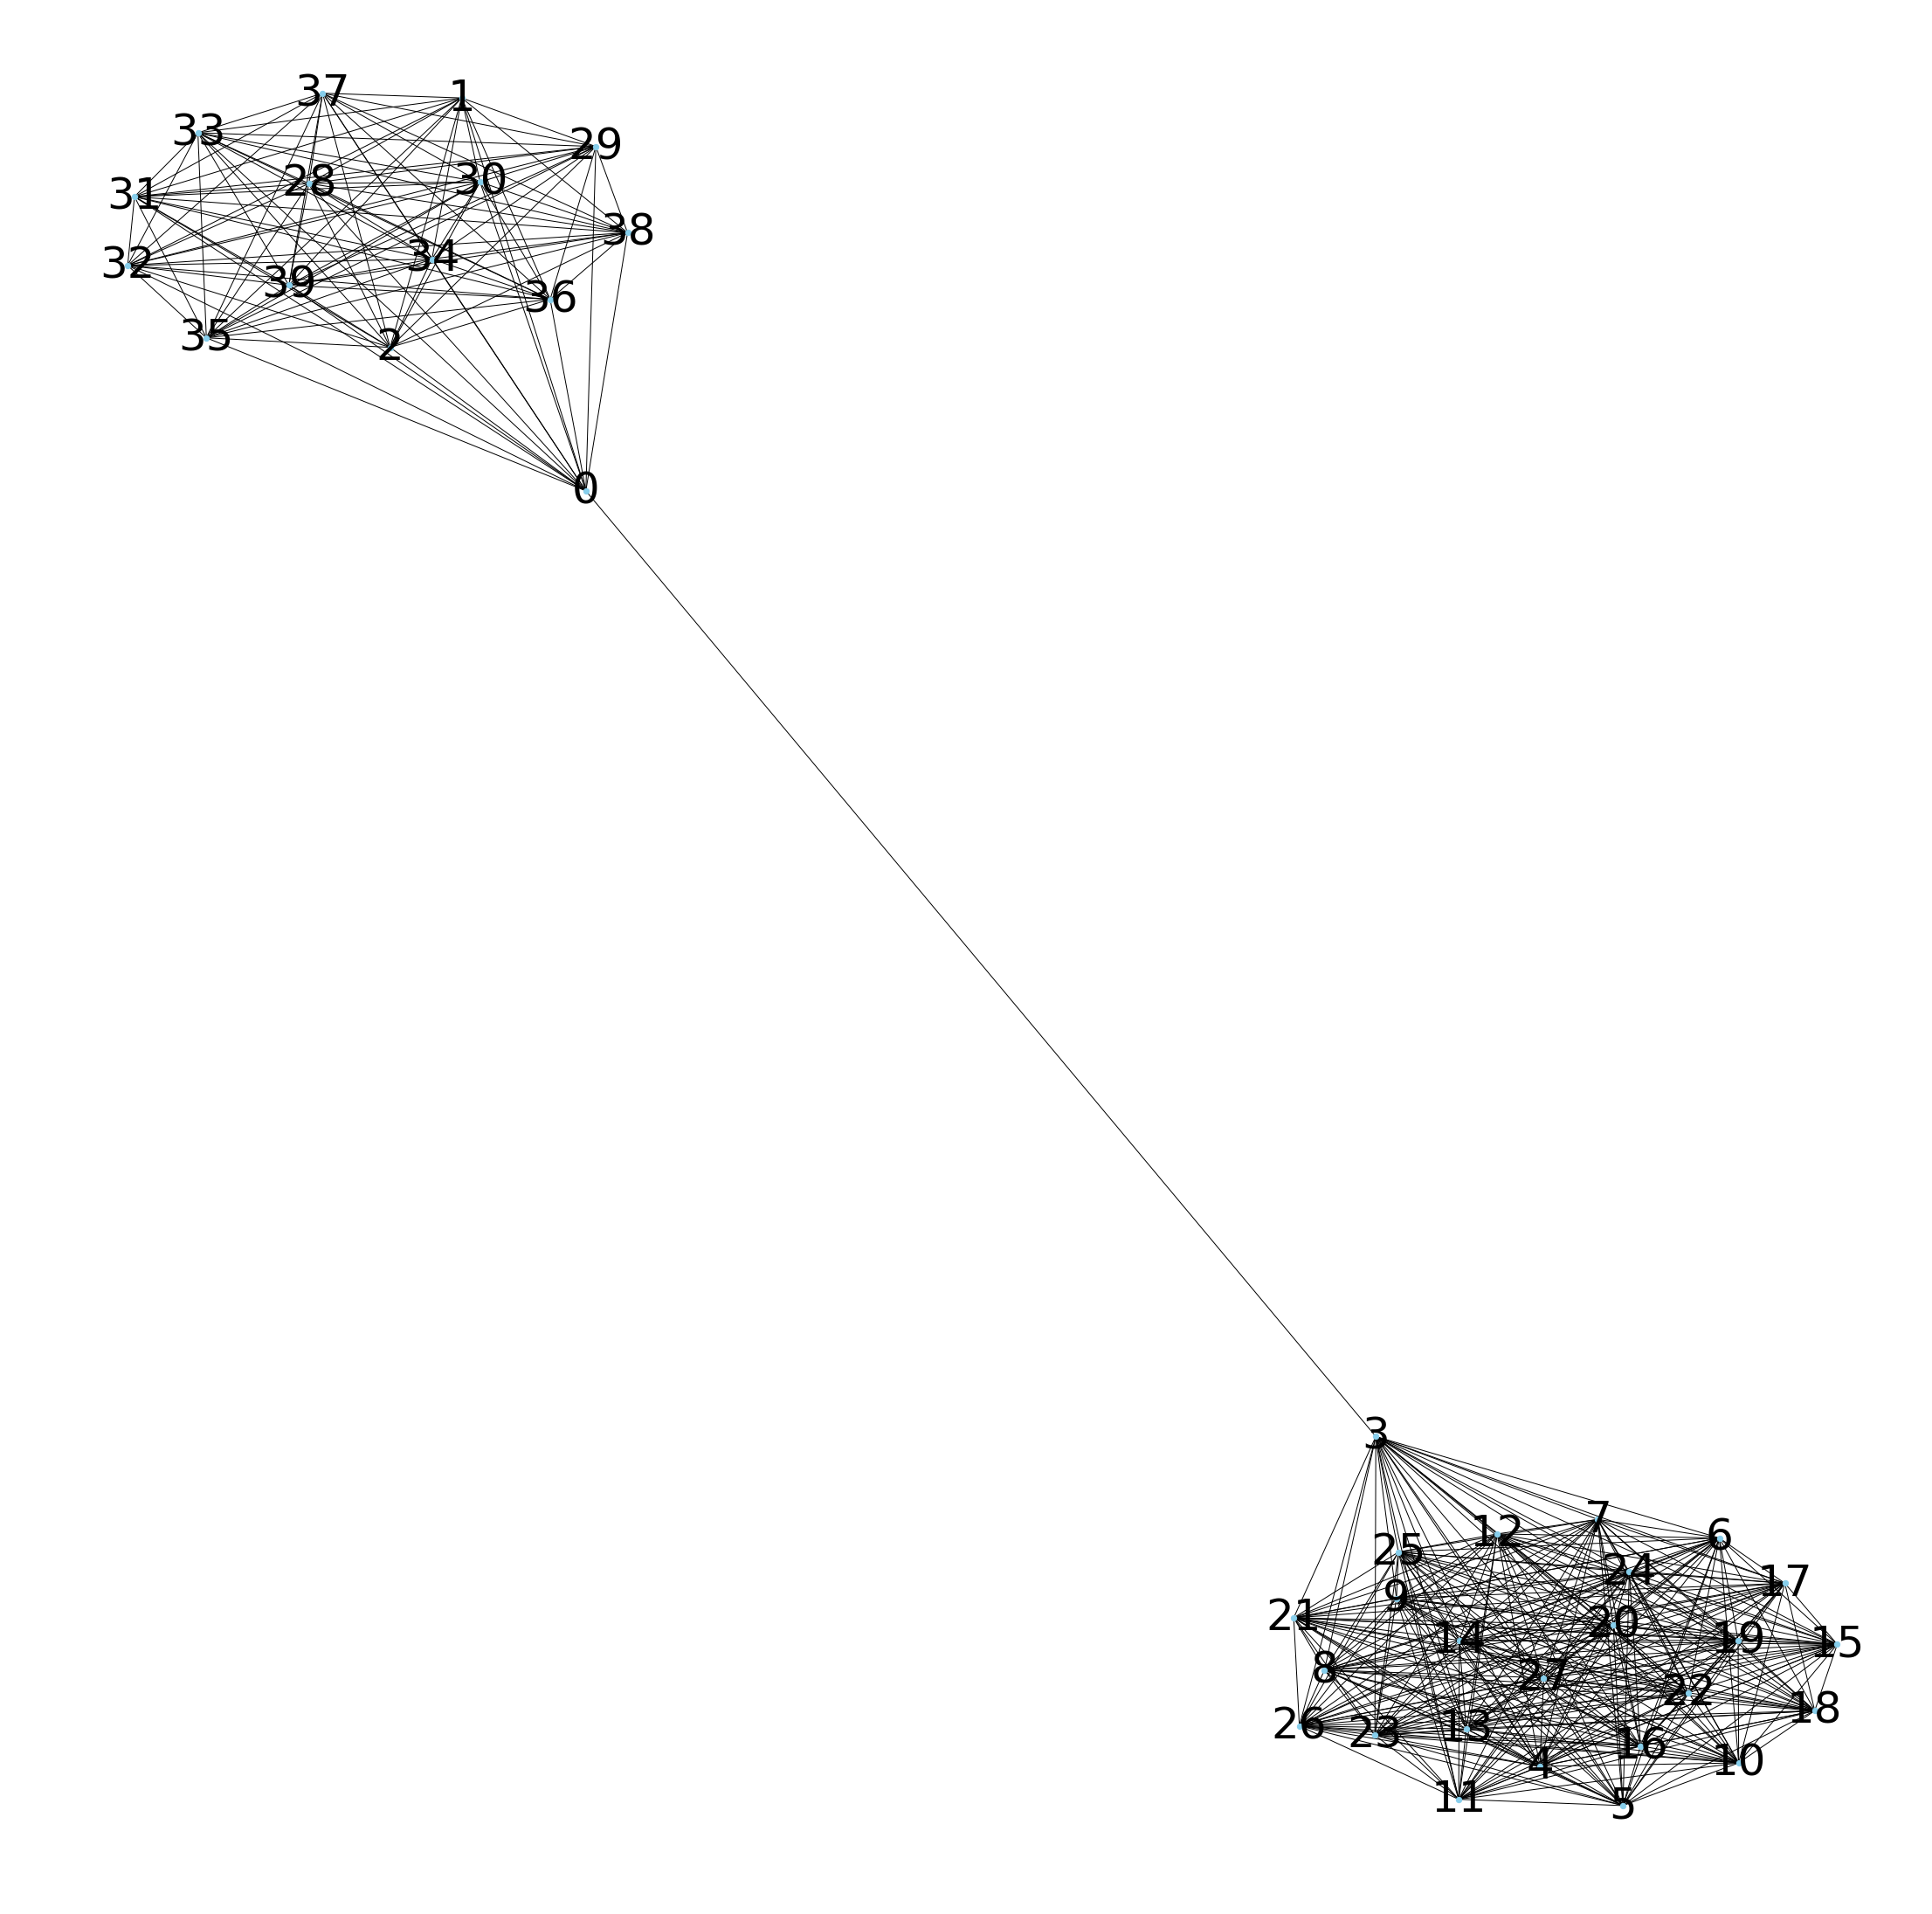

In [435]:
draw_graph(G0)

Таким образом, у нас есть 3 графа: 2 полных (80 и 43 вершины) и 1 почти обычный (40 вершин).

Теперь можно сравнить графы, разные по свойствам, но одинаковые по размеру, одинаковые по свойствам и тд...

# 4) Graph Edit Distance

In [156]:
def complete_graph_distance(G1, G2):
    n1 = len(G1)
    m1 = len(G1.edges())
    
    n2 = len(G2)
    m2 = len(G2.edges())
    
    return abs(n1-n2) + abs(m1-m2)

In [190]:
complete_graph_distance(G1, G2)

2294

К сожалению, проверить подсчет на выбранных графах с помощью networkx мне не удалось(я просто не смог дождаться, пока досчитает). Поэтому, думаю, стоит проверить вычисления на графах поменьше, к примеру, 2002 и 2010 годов

In [198]:
complete_graph_distance(Graphs[2], Graphs[10]) == nx.graph_edit_distance(Graphs[2], Graphs[10])

True

Даже для таких относительно малых графов, GED считался довольно долго

О боже мой, как же так получилось, что мы смогли сократить NP сложный алгоритм до одной строчки.

А дело в том, что мы всегда сможем найти любой граф(меньший по количеству вершин) в подграфе полного графа и нам останется лишь добавить недостающие вершины и ребра.

Я не стал считать операцию relabel, тк все вершины для каждого года называются по-разному, точнее все названия начинаются с года.

Если же мы хотим посчитать GED с этой операцией, нам достаточно добавить количество вершин меньшего из графов. Опять же, находим полный подграф, переименовываем в лэйблы нашего меньшего графа и удаляем ненужные ребра и вершины. Или же сначала переименовываем малый граф и достраиваем до бОльшего.


Теперь хочется понять, можно ли использовать такую же функцию, когда меньший из графов не полный.

Ответ - да. Особенно в нашем случае, когда неполный граф меньше любого из наших полных. Мы также можем найти подграф, который будет равен неполному и останется лишь удалить вершины.

In [533]:
GED_G01 = complete_graph_distance(G0, G1)
GED_G12 = complete_graph_distance(G1, G2)
GED_G02 = complete_graph_distance(G0, G2)


print('G0 vs G1:', complete_graph_distance(G0, G1))
print('G1 vs G2:', complete_graph_distance(G1, G2))
print('G0 vs G2:', complete_graph_distance(G0, G2))

G0 vs G1: 500
G1 vs G2: 2294
G0 vs G2: 2794


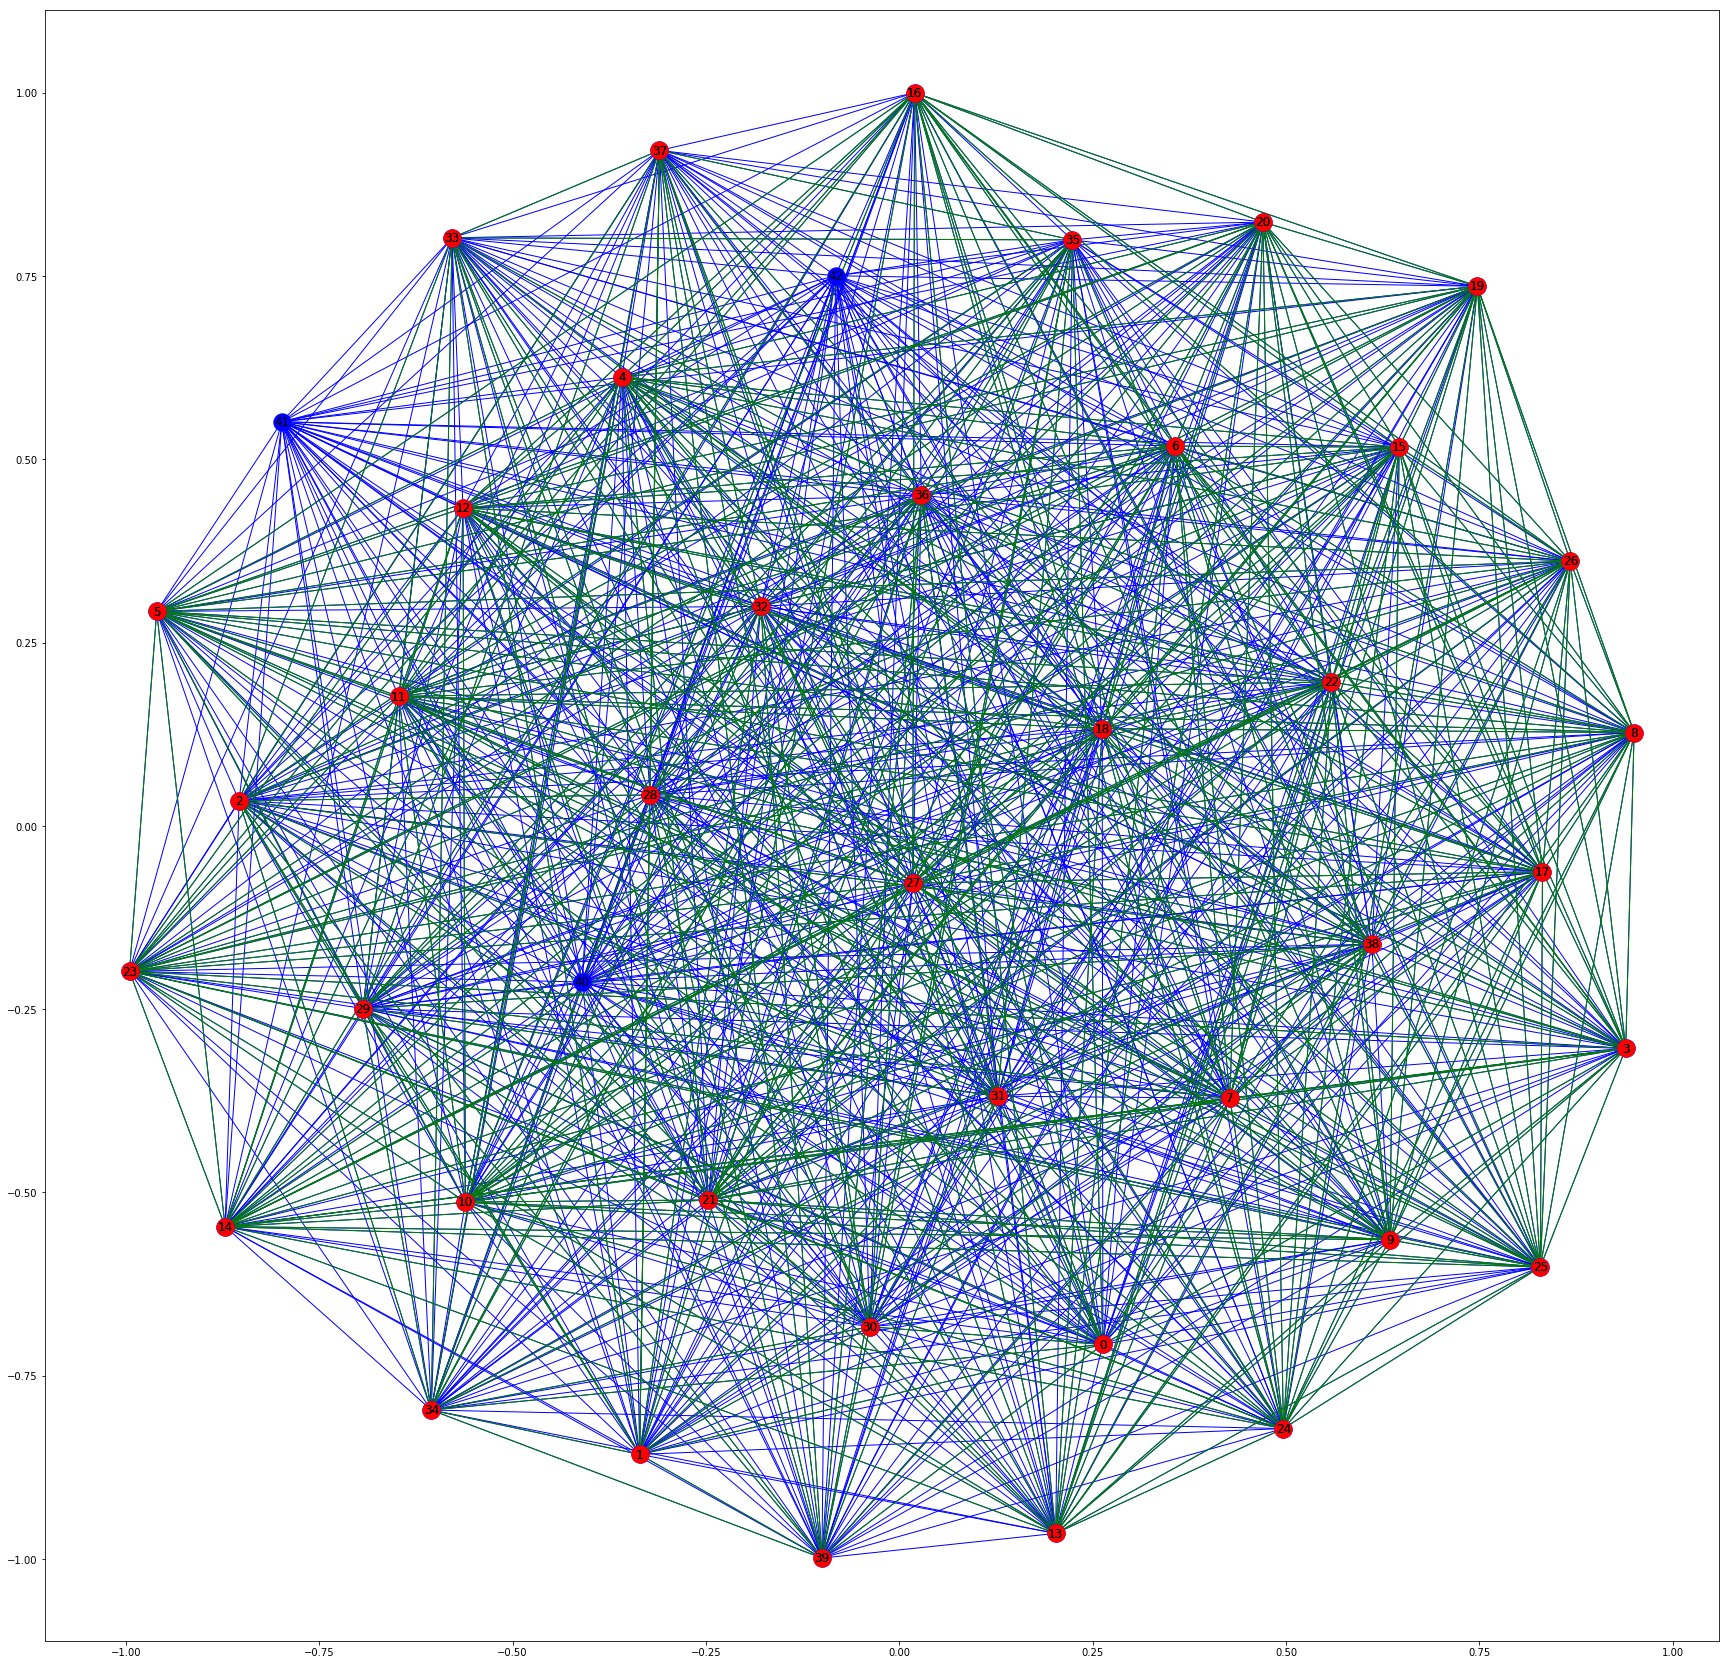

In [470]:
from copy import deepcopy
from matplotlib import pylab as pl


first = deepcopy(G0)
second = deepcopy(G1)

H = second.edge_subgraph(first.edges())

pos = nx.spring_layout(second)  #setting the positions with respect to G, not k.


pl.figure(3,figsize=(30,30))
nx.draw_networkx(second, pos=pos, node_color = 'b', edge_color='b')
colors = ['g' if edg in first.edges() else 'b' for edg in H.edges()]
nx.draw_networkx(H, pos=pos, edge_color=colors)

othersubgraph = second.subgraph(range(len(first),second.order()))

pl.show()

Я надеялся, что хоть что-то будет видно на графе, но получилось немного не так красиво, как я ожидал, но тут можно разглядеть граф G0, который раскрашен красными вершинами и зелеными ребрами.

В общем так я хотел показать, что действительно любой граф, меньший по размеру можно вписать в полный.

## Вывод

В качестве некой метрики, можно попробовать нормализировать граф, поделив полученные величины на среднее количество вершин

In [542]:
print('G0 vs G1, normalized by avg node num:', GED_G01/((len(G0) + len(G1))/2))
print('G0 vs G2, normalized by avg node num:', GED_G02/((len(G0) + len(G2))/2))
print('G1 vs G2, normalized by avg node num:', GED_G12/((len(G1) + len(G2))/2))

G0 vs G1, normalized by avg node num: 12.048192771084338
G0 vs G2, normalized by avg node num: 46.56666666666667
G1 vs G2, normalized by avg node num: 37.300813008130085


In [543]:
print('G0 vs G1, normalized by avg node+edge num:', GED_G01/((len(G0) + len(G1) + len(G0.edges()) + len(G1.edges()))/2))
print('G0 vs G2, normalized by avg node+edge num:', GED_G02/((len(G0) + len(G2) + len(G0.edges()) + len(G2.edges()))/2))
print('G1 vs G2, normalized by avg node+edge num:', GED_G12/((len(G1) + len(G2) + len(G1.edges()) + len(G2.edges()))/2))

G0 vs G1, normalized by avg node+edge num: 0.7183908045977011
G0 vs G2, normalized by avg node+edge num: 1.5160065111231686
G1 vs G2, normalized by avg node+edge num: 1.0960344003822264


Если нормализировать по среднему количеству узлов, то это вроде ничего особо нам не скажет. Думаю, если также нормализировать по количеству ребер, будет такой же результат. А вот если брать среднее количество ребер и узлов, то мы получаем более интересный результат

Можно смотреть на близость такого коэффициента к 1, таким образом, такая метрика показывает, на нашах графах, что полные графы близки, тогда как "гантелька" отличается и от большого графа, так и от маленького. Хотя, стоит проверить близость "гантельки" к полному графу средней величины

In [548]:
compl_55 = nx.complete_graph(55)
GED_compl_vs_0 = complete_graph_distance(G0, compl_55)
avg = (len(G0) + len(G0.edges()) + len(compl_55) + len(compl_55.edges()))/2
print('G0 vs compl_55, normalized by avg node+edge num:', GED_compl_vs_0/avg)

G0 vs compl_55, normalized by avg node+edge num: 1.1017119838872105


Так выяснилось, что такая нормализация нам ничего не дает, увы. Тогда, думаю, можно сравнивать схожесть графа по объему, чем меньше, тем болше схожи графы

_______________________________

Далее я решил оставить попытки написать сам алгоритм, но я так и не понял, как считать операции над ребрами даже после просмотра исходников networkx.

Там много странных оптимизаций матриц весов.

In [1]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import networkx as nx

def GED(G1, G2):    
    def insert_cost(i, j, nodes2):
        if i == j:
            return 1
        else:
            return 999
    
    def delete_cost(i, j, nodes1):
        if i == j:
            return 1
        return 999
    
    def relabel_cost(node1, node2):
        if node1 == node2:
            return 0
        else:
            return 1
        
    def substitute_cost(node1, node2):
        return relabel_cost(node1, node2) + edge_diff_1(node1, node2)
    
    def edge_diff_1(node1, node2):
        edges_1 = list(G1.edges(node1))
        edges_2 = list(G2.edges(node2))
        
        if len(edges_1) == 0 or len(edges_2) == 0:
            return max(len(edges_1), len(edges_2))
        return edge_dist(edges_1, edges_2)
    
    def edge_dist(edges_1, edges_2):
        to_nodes_1 = [edge[1] for edge in edges_1]
        to_nodes_2 = [edge[1] for edge in edges_2]
        
        common_n = 0
        
        for to_node_1 in to_nodes_1:
            if to_node_1 in to_nodes_2:
                common_n += 1
        rest_1 = len(to_nodes_1) - common_n
        rest_2 = len(to_nodes_2) - common_n
        
        return max(rest_1, rest_2) 

    n = len(G1)
    m = len(G2)
    
    cost_matrix = np.zeros((n+m,n+m))
    
    nodes_1 = list(G1.nodes())
    nodes_2 = list(G2.nodes())
    
    for i in range(n):
            for j in range(m):
                cost_matrix[i,j] = substitute_cost(nodes_1[i], nodes_2[j])
    
    for i in range(m):
            for j in range(m):
                cost_matrix[i+n,j] = insert_cost(i, j, nodes_2)
    
    for i in range(n):
            for j in range(n):
                cost_matrix[j,i+m] = delete_cost(i, j, nodes_1)
                
    row_ind,col_ind = linear_sum_assignment(cost_matrix)
    print(cost_matrix)
    return sum([cost_matrix[row_ind[i]][col_ind[i]] for i in range(len(row_ind))])

# 5) Метрики

## 5.1) Diameter




***Диаметр графа***
\- самое длинное кратчайшее расстояние между двумя вершинами графа

На наших полных графах диаметр равен 1, нооо, думаю, что стоит написать функцию по подсчету его для общего случая, используя алгоритм Флойда-Уоршелла.

In [473]:
def diameter(G):
    n = len(G)
    matr = np.full((n, n), np.inf)
    for node in range(n):
        matr[node, node] = 0
    for edge in G.edges():
        matr[edge[0], edge[1]] = 1
        matr[edge[1], edge[0]] = 1
        
    for k in range(n):
        for i in range(n):
            for j in range(n):
                matr[i, j] = min(matr[i, j], matr[i, k] + matr[k, j])
    
    max_path = 0
    for i in range(n):
        for j in range(i):
            if max_path < matr[i, j]:
                max_path = matr[i, j]
    return max_path

In [477]:
diameter(G1)

1.0

In [476]:
diameter(G2)

1.0

In [475]:
diameter(G0)

3.0

## Вывод

В "гантельке" есть вершины, далекие друг от друга, когда в полных графах все вершины близки друг к другу (смежные)

## 5.2) Eccentricity

***Эксцентриситет вершины графа*** \- максимальное кратчайший путь между данной вершиной и любой другой вершиной в графе

***Максимальная эксцентриситет графа*** \- диаметр графа

***Минимальная эксцентриситет графа*** \- радиус графа


In [502]:
def eccentriciti(G):
    n = len(G)
    matr = np.full((n, n), np.inf)
    for node in range(n):
        matr[node, node] = 0
    for edge in G.edges():
        matr[edge[0], edge[1]] = 1
        matr[edge[1], edge[0]] = 1
        
    for k in range(n):
        for i in range(n):
            for j in range(n):
                matr[i, j] = min(matr[i, j], matr[i, k] + matr[k, j])
    
    ecc = []
    for i in range(n):
        max_path = 0
        for j in range(n):
            if max_path < matr[i, j]:
                max_path = matr[i, j]
        ecc.append(max_path)
    return ecc

In [505]:
G0_ecc = eccentriciti(G0)
G1_ecc = eccentriciti(G1)
G2_ecc = eccentriciti(G2)

In [508]:
min(G0_ecc)

2.0

## Вывод

Следующая характеристика лучше все описывает

## 5.3) Periphery

***Периферийные вершины*** имеют эксцентриситет, равный диаметру.

In [530]:
def draw_periphery(G, ecc):
    g_diameter = max(ecc)

    pos = nx.spring_layout(G)
    colors = ['r' if g_diameter == n_ecc else 'b' for n_ecc in ecc]

    pl.figure(2,figsize=(5,5))
    nx.draw_networkx(G, pos=pos, node_color = colors)
    pl.show()

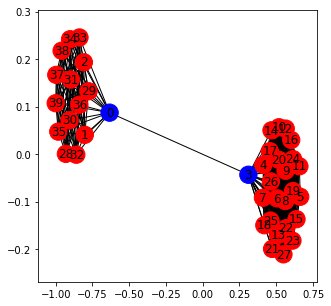

In [518]:
draw_periphery(G0, G0_ecc)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


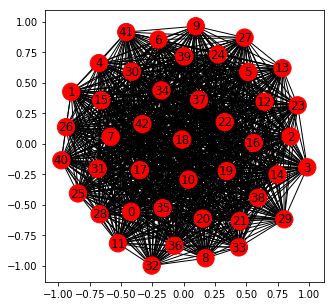

In [519]:
draw_periphery(G1, G1_ecc)

***Центр графа*** - вершины, у которых эксцентриситет равен радиусу

In [527]:
def draw_centre(G, ecc):
    g_radius = min(ecc)

    pos = nx.spring_layout(G)
    colors = ['r' if g_radius == n_ecc else 'b' for n_ecc in ecc]

    pl.figure(2,figsize=(5,5))
    nx.draw_networkx(G, pos=pos, node_color = colors)
    pl.show()

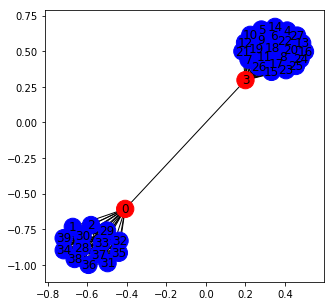

In [529]:
draw_centre(G0, G0_ecc)

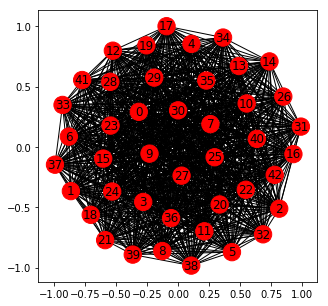

In [531]:
draw_centre(G1, G1_ecc)

### Вывод

Эта характеристика явно показывается отличие наших двух типов графов

В "гантельке" явно выделяются переферийные вершины (2 сообщества), которые контактируют через центральные вершины графа.

В полных же графах переферия графа равна центру, что значит, что все вершины тесно связамы между собой

## 5.4) Girth

***Обхват графа*** - размер наименьшего цикла в графе

3 на всех графах

## Вывод
Это может означать, что информация или указания рапространяются довольно быстро по таким маленьким сообществам, а т.к. всего таких циклов очень много, то информация по вчему графу будет быстро распространяться

По данной характеристике все графы похожи, однако, если учитывать прошлую характеристику, можно понять, что в "гантельке" есть 2 сообщества, которые тесно общаются друг с другом, а в полных - одно большое



## 5.5) Expansion

Тут я почему то не смог найти нормальной теории, увы

# 6) Wiener Index

Вот этот алгоритм приятный.

Пишется и работает быстро.

Для этого индекса реализуем алгоритм Флойда-Уоршелла для нахождения кратчайших путей между всеми парами вершин и просто просуммируем полученные значения.

In [480]:
def wienner(G):
    n = len(G)
    matr = np.full((n, n), np.inf)
    for node in range(n):
        matr[node, node] = 0
    for edge in G.edges():
        matr[edge[0], edge[1]] = 1
        matr[edge[1], edge[0]] = 1
        
    for k in range(n):
        for i in range(n):
            for j in range(n):
                matr[i, j] = min(matr[i, j], matr[i, k] + matr[k, j])
    
    ind = 0
    for i in range(n):
        for j in range(i):
            ind += matr[i,j]
    return ind

In [481]:
print('G0:', wienner(G0))
print('G1:', wienner(G1))
print('G2:', wienner(G2))

G0: 1490.0
G1: 903.0
G2: 3160.0


In [482]:
print('G0:', nx.wiener_index(G0))
print('G1:', nx.wiener_index(G1))
print('G2:', nx.wiener_index(G2))

G0: 1490.0
G1: 903.0
G2: 3160.0


### Метрика

Думаю, что этот индекс лучше всего использовать для подсчета среднего кратчайшего расстояния между вершинами.

То есть некую достяжимость из каждой вершины до каждой.

Для этого нам всего лишь надо поделить данный индекс на число сочетаний, то есть:

$$\frac{wienner(G)}{C^{2}_n}$$

In [217]:
def metric_6(G):
    return wienner(G)/(len(G)* (len(G)-1)/2)

In [484]:
print('G0:', metric_6(G0))
print('G1:', metric_6(G1))
print('G2:', metric_6(G2))

G0: 1.9102564102564104
G1: 1.0
G2: 1.0


## Вывод

Полные графы не похожы по данной характеристике, однако, если использовать усреднение, то можно будет явно сказать, что они ооочень похожи. И что, средний путь от одной до другой вершины равен одному ребру, однако для "гантельки" это среднее расстояние почти в 2 раза больше, чем у полных графов. Собственно, средний путь примерно равен двум. Т.к. по своим сообществам они могут перейти друг к другу по одному ребру, а если в другое надо, то уже придется переходить по 3м.

# 7) Hosoya Index

In [124]:
from copy import deepcopy
index = 1
def hosoya(G):
    edges = G.edges()
    n = len(edges)
    index = [1]
    for k in range(1, int(n/2+1)):
        index+= list(choose_k_edges(list(G.edges()), k, 0, [], [], 0))
    return sum(index)
        
def choose_k_edges(edges, k_req, k_cur, used_edges, used_nodes, last_i):
    for i, edge in enumerate(edges[last_i:]):
        #print(k_req, k_cur, edge, used_nodes, used_edges)
        if edge not in used_edges and edge[0] not in used_nodes and edge[1] not in used_nodes:
            e = deepcopy(used_edges)
            n = deepcopy(used_nodes)
            e.append(edge)
            n.append(edge[0])
            n.append(edge[1])
            
            if k_cur+1 == k_req:
                yield(1)     
            else:
                yield(sum(list(choose_k_edges(edges, k_req, k_cur+1, e, n, i+last_i))))

In [205]:
compl = nx.complete_graph(10)
hosoya(compl)

9496

Был реализован простой перебор всех возможных наборов ребер


Запустив алгоритм перебора на полных графах и взяв результаты из вики, можно удостовериться, что все работает правильно, однако, такой подход нам не подходит, тк данный алгоритм также является NP полным и мы просто не дождемся его выполнения на наших графах.

Для того, чтобы все же посчитать этот индекс, я решил использовать найденные формулы для полного графа

#### 1) Рекурсивная формула a(n) = a(n-1) + (n-1)*a(n-2), n>1 

a(n) is also the number of matchings (Hosoya index) in the complete graph 

(https://oeis.org/A000085)

In [403]:
def recursive_hosoya(n):
    calced_rec = [1, 1] + [0] * n
    def rec(n, calced_rec):
        if calced_rec[n]:
            return calced_rec[n]
        res = rec(n-1, calced_rec) + (n-1) * rec(n-2, calced_rec)
        if not n in calced_rec:
            calced_rec[n] = res
        return res
    return rec(n, calced_rec)
calc_hos(len(G2))

245789798368839780414239398545880224872312250090845785136562176

#### 2) Коэффициенты Matching-Generating Polynomial
Вторую формулу для проверки я взял с сайта вольфрама(http://mathworld.wolfram.com/Matching.html)

In [396]:
from math import factorial
def fac(k):
    if k == 0:
        return 1
    
    result = k
    for i in range(1, k):
        result *= i
    return int(result)

def d_fac(k):
    if k == 0 or k == -1:
        return 1
    result = 1
    for i in range(k, 0, -2):
        result *= i
    return int(result)    

def complete_hosoya(n):    
    ind = 0
    for k in range(int(n/2)+1):
        top = 1
        for i in range(n, n-2*k, -1):
            top*=i
        q = d_fac(2*k)*factorial(n - 2*k)
        if factorial(n) % q:
            print(k)
        ind += factorial(n)//q
    return ind

In [404]:
print(complete_hosoya(len(G1)) == recursive_hosoya(len(G1)))
print(complete_hosoya(len(G2)) == recursive_hosoya(len(G2)))

True
True


In [405]:
print('G1:', complete_hosoya(len(G1)))
print('G2:', complete_hosoya(len(G2)))

G1: 24484510749551977163109658624
G2: 245789798368839780414239398545880224872312250090845785136562176


Теперь надо посчитать этот индекс для графа G0

Однако напрямую данную функцию применять нельзя, т.к. наш граф не полный. Однако, если вспомнить, что это "гантелька" состоит из двух полных графов, соединенных мостом.

Тогда индекс Хосойи будем считать так:

Рассмотрим 2 случая: когда наш мост не входит в паросочетания и когда наоборот, входит.

1) Мост не входит в паросочетание. 

Тогда мы берем произведение индексов для левой и правой клики

2) Мост входит в паросочетание.

Берем индекс от левой и правой клики, но убирая из них одну вершину, которая как раз и входит в паросочетание, т.к. ни одно смежное с ним ребро входить в паросочетание не может. И снова их перемножаем.

Ну и в конце концов суммировем полученные значения.

Выше можно посмотреть, что у одной из нашей клик 25 вершин, у другой 15.

In [488]:
G0_hosoya = complete_hosoya(25)*complete_hosoya(15) + complete_hosoya(24)*complete_hosoya(14)
print('G0:', G0_hosoya)

G0: 1032062928927997940736


## Вывод

Тут довольно сложно что-либо придумать, такие числа довольно сильно возрастают. Т.к. максимальное количество возможных паросочетаний, мы получаем на полных графах, можно попробовать сделать так: можно перевести это в коэффициент схожести с полным графом, а потом уже эти коэффициенты сравнить.

То есть, для неполных графов можно взять индекс Хосойа от количества вершин неполного графа. Поделить одно на другое. Ну и взять логарифм, чтобы грасивее было, ибо эти числа оооочень быстро возрастают и близки к нолю.

In [560]:
def metric_7(G, G_hosoya_ind):
    hosoya_compl= complete_hosoya(len(G))
    return -np.log(G_hosoya_ind/hosoya_compl)

In [559]:
print('G0:', metric_7(G0, G0_hosoya))
print('G1:', metric_7(G1, complete_hosoya(len(G1))))
print('G2:', metric_7(G2, complete_hosoya(len(G2))))

G0: -11.162293541136647
G1: -0.0
G2: -0.0


Примерно так можно смотреть, насколько граф похож на полный

Также, думаю, хорошей идеей станет использовать такую метрику:

In [561]:
def metric_7_1(G1_hosoya, G2_hosoya):
    return abs(np.log(G1_hosoya / G2_hosoya))

In [562]:
metric_7_1(G0_hosoya, complete_hosoya(len(G2)))

95.2737356764064

In [563]:
metric_7_1(G0_hosoya, complete_hosoya(len(G1)))

16.9819916184355

In [564]:
metric_7_1(complete_hosoya(len(G2)), complete_hosoya(len(G1)))

78.2917440579709

Такой способ лучше отображает разницу по размеру, а прошлый скорее отражал по характеристикам

# 8) Ядро графа

Начнем с теории.

***Внутренне устойчивое множество***
\- такое множество вершин, что никакие две вершины из него не смежны

***Внешне устойчивое множество***
\- такое множество вершин, что для каждой вершины, не входящей в это множество, существует ребро, ведущее в это множество

***Ядро графа***
\- такое множество вершин, которое одновременно внешне и внутренне уствойчиво

Таким образом, т.к. 2 наших выбранных графа являются полными, в качестве их ядер можно взять любую вершину каждого графа, но только одну, иначе выбранное множество не будет внутренне устойчивым.

А для нашей "гантельки" можно взять любые 2 вершины такие, что первая вершина будет находится в одной части графа, а вторая - в другой, однако они не могут одновременно находиться на мосту, иначе множество не будет внутренне устойчиво.

Также нель выбрать только одну вершину, т.к. множество не будет внешне уствойчиво

## Вывод

Думаю, тут уже идет идет посдчет количества сообществ, которые образуются в графа, про эти сообщества я говорил в пункту 5.4. Сравнивать можно по разнице количества сообществ, насколько "един" граф

In [565]:
def metric_8(core_1, core_2):
    return abs(core_1 - core_2)

In [566]:
metric_8(1, 1)

0